In [2]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV, cross_val_score

# XGBoost
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load preprocessed data
train_df = pd.read_csv('data/train_reviews.csv')
test_df = pd.read_csv('data/test_reviews.csv')

X_train_text = train_df['review']
y_train = train_df['sentiment']
X_test_text = test_df['review']
y_test = test_df['sentiment']

print(f" Data loaded")
print(f"Training samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")

 Data loaded
Training samples: 7336
Test samples: 1834


In [4]:
# Load TF-IDF vectorizer (best performer from feature extraction)
with open('models/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Transform data
X_train = tfidf_vectorizer.transform(X_train_text)
X_test = tfidf_vectorizer.transform(X_test_text)

print(f" TF-IDF vectorizer loaded")
print(f"Feature shape: {X_train.shape}")

 TF-IDF vectorizer loaded
Feature shape: (7336, 167)


In [5]:
# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Train and evaluate a model, returning metrics
    """
    print(f"\nTraining {model_name}...")
    print("=" * 60)
    
    # Train model
    import time
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    # ROC AUC (if probability predictions available)
    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_proba)
    except:
        roc_auc = None
    
    # Print results
    print(f"Training time: {train_time:.2f} seconds")
    print(f"\nTraining Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy:     {test_accuracy:.4f}")
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC:   {roc_auc:.4f}")
    
    # Return metrics dictionary
    return {
        'model_name': model_name,
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'train_time': train_time,
        'y_pred': y_test_pred
    }

print(" Evaluation function defined")

 Evaluation function defined


In [6]:
# Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

lr_results = evaluate_model(lr_model, X_train, y_train, X_test, y_test, 'Logistic Regression')


Training Logistic Regression...
Training time: 0.02 seconds

Training Accuracy: 1.0000
Test Accuracy:     1.0000

Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC AUC:   1.0000


In [7]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test, 'Random Forest')


Training Random Forest...
Training time: 0.38 seconds

Training Accuracy: 1.0000
Test Accuracy:     1.0000

Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC AUC:   1.0000


In [8]:
# SVM with linear kernel (better for text classification)
svm_model = SVC(
    kernel='linear',
    class_weight='balanced',
    probability=True,  # Enable probability predictions
    random_state=42
)

svm_results = evaluate_model(svm_model, X_train, y_train, X_test, y_test, 'SVM (Linear)')


Training SVM (Linear)...
Training time: 0.09 seconds

Training Accuracy: 1.0000
Test Accuracy:     1.0000

Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC AUC:   1.0000


In [9]:
# Multinomial Naive Bayes (ideal for text classification)
nb_model = MultinomialNB(alpha=1.0)

nb_results = evaluate_model(nb_model, X_train, y_train, X_test, y_test, 'Naive Bayes')


Training Naive Bayes...
Training time: 0.00 seconds

Training Accuracy: 1.0000
Test Accuracy:     1.0000

Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC AUC:   1.0000


In [10]:
# XGBoost
# Calculate scale_pos_weight for class imbalance
negative_count = (y_train == 0).sum()
positive_count = (y_train == 1).sum()
scale_pos_weight = negative_count / positive_count

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_results = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, 'XGBoost')


Training XGBoost...
Training time: 0.10 seconds

Training Accuracy: 1.0000
Test Accuracy:     1.0000

Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC AUC:   1.0000


In [11]:
# Compile all results
all_results = [lr_results, rf_results, svm_results, nb_results, xgb_results]

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['test_accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1_score'],
        'ROC AUC': r['roc_auc'] if r['roc_auc'] else 0,
        'Train Time (s)': r['train_time']
    }
    for r in all_results
])

# Sort by F1-Score
comparison_df = comparison_df.sort_values('F1-Score', ascending=False).reset_index(drop=True)

print("\n" + "=" * 80)
print("MODEL COMPARISON (Sorted by F1-Score)")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_f1 = comparison_df.iloc[0]['F1-Score']
print(f"\n BEST MODEL: {best_model_name} (F1-Score: {best_f1:.4f})")


MODEL COMPARISON (Sorted by F1-Score)
              Model  Accuracy  Precision  Recall  F1-Score  ROC AUC  Train Time (s)
Logistic Regression       1.0        1.0     1.0       1.0      1.0        0.022888
      Random Forest       1.0        1.0     1.0       1.0      1.0        0.377398
       SVM (Linear)       1.0        1.0     1.0       1.0      1.0        0.090509
        Naive Bayes       1.0        1.0     1.0       1.0      1.0        0.001557
            XGBoost       1.0        1.0     1.0       1.0      1.0        0.101472

 BEST MODEL: Logistic Regression (F1-Score: 1.0000)


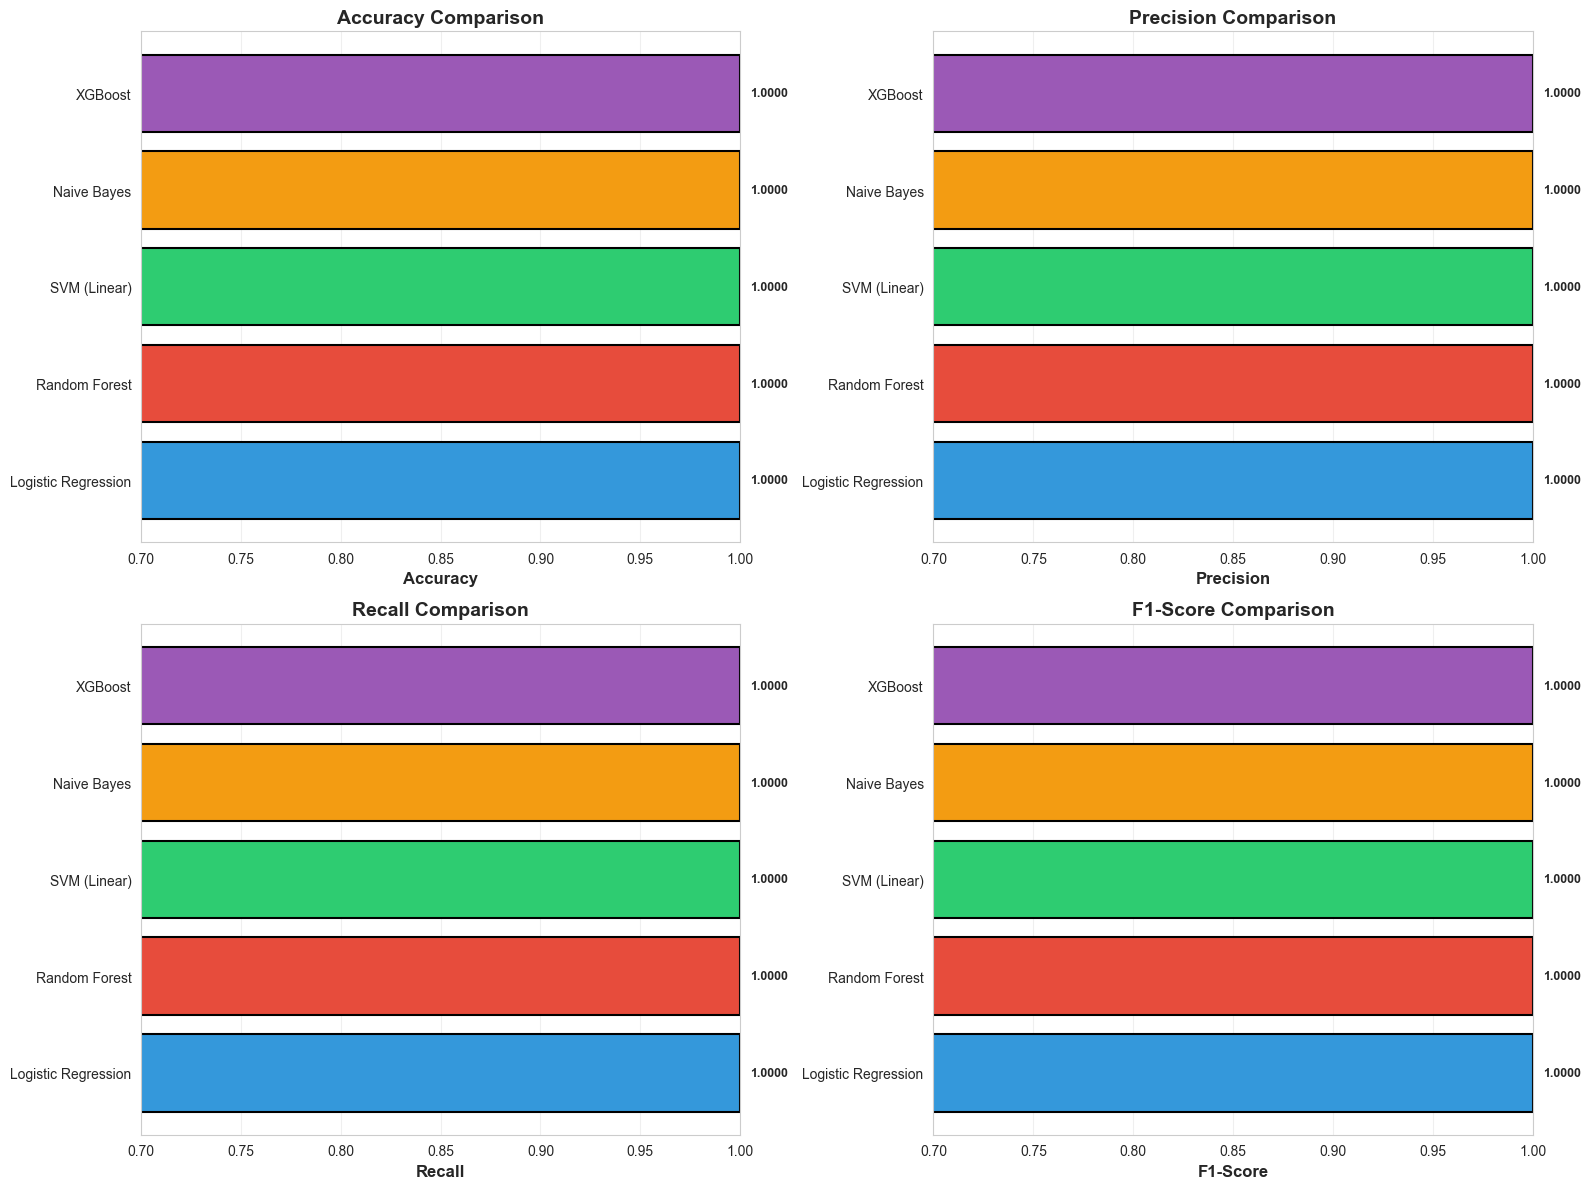

In [12]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by current metric
    sorted_df = comparison_df.sort_values(metric, ascending=False)
    
    bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=colors, edgecolor='black', linewidth=1.5)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlim([0.7, 1.0])
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (model, value) in enumerate(zip(sorted_df['Model'], sorted_df[metric])):
        ax.text(value + 0.005, i, f'{value:.4f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

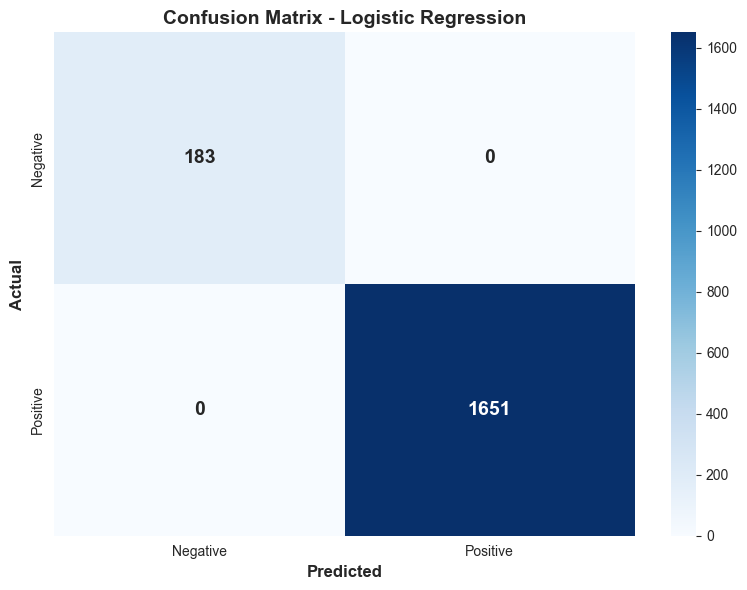


Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       183
    Positive       1.00      1.00      1.00      1651

    accuracy                           1.00      1834
   macro avg       1.00      1.00      1.00      1834
weighted avg       1.00      1.00      1.00      1834



In [13]:
# Get best model results
best_result = all_results[0]  # Already sorted by F1
for r in all_results:
    if r['model_name'] == best_model_name:
        best_result = r
        break

# Confusion matrix
cm = confusion_matrix(y_test, best_result['y_pred'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(y_test, best_result['y_pred'], 
                          target_names=['Negative', 'Positive']))

In [14]:
print("\nPerforming hyperparameter tuning for best model...")
print("=" * 60)

# Define parameter grid based on best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    }
    base_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [15, 20, 25],
        'min_samples_split': [2, 5]
    }
    base_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

elif best_model_name == 'SVM (Linear)':
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    }
    base_model = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)

elif best_model_name == 'Naive Bayes':
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 2.0]
    }
    base_model = MultinomialNB()

else:  # XGBoost
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1]
    }
    base_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')

# Grid search with cross-validation
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print(f"\nSearching through {len(list(grid_search.get_params()['estimator'].__class__(**param_grid).get_params()))} parameter combinations...")
grid_search.fit(X_train, y_train)

print("\n Hyperparameter tuning completed!")
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-Score: {grid_search.best_score_:.4f}")


Performing hyperparameter tuning for best model...

Searching through 15 parameter combinations...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Hyperparameter tuning completed!

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation F1-Score: 1.0000


In [15]:
# Evaluate tuned model
best_tuned_model = grid_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test)

tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_precision = precision_score(y_test, y_pred_tuned)
tuned_recall = recall_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)

print("\nTuned Model Performance:")
print("=" * 60)
print(f"Accuracy:  {tuned_accuracy:.4f}")
print(f"Precision: {tuned_precision:.4f}")
print(f"Recall:    {tuned_recall:.4f}")
print(f"F1-Score:  {tuned_f1:.4f}")

print(f"\nImprovement over baseline:")
print(f"F1-Score: {best_f1:.4f} → {tuned_f1:.4f} ({(tuned_f1 - best_f1):.4f})")


Tuned Model Performance:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

Improvement over baseline:
F1-Score: 1.0000 → 1.0000 (0.0000)


In [16]:
# Save the best tuned model
print("\nSaving best model...")
print("=" * 60)

# Save model
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(best_tuned_model, f)
print(" Saved: models/best_model.pkl")

# Save vectorizer (TF-IDF) - already saved but include for completeness
with open('models/vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(" Saved: models/vectorizer.pkl")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'best_params': grid_search.best_params_,
    'test_accuracy': tuned_accuracy,
    'test_precision': tuned_precision,
    'test_recall': tuned_recall,
    'test_f1_score': tuned_f1,
    'vectorizer': 'TF-IDF',
    'feature_count': X_train.shape[1]
}

with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)
print(" Saved: models/model_metadata.pkl")


Saving best model...
 Saved: models/best_model.pkl
 Saved: models/vectorizer.pkl
 Saved: models/model_metadata.pkl


In [17]:
# Test the saved model
print("\nTesting saved model...")
print("=" * 60)

# Load model and vectorizer
with open('models/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
with open('models/vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)

# Test with sample reviews
sample_reviews = [
    "This tea is absolutely amazing! Best quality and great taste.",
    "Terrible product. Complete waste of money. Very disappointed.",
    "Good tea for the price. Would recommend to others.",
    "Not fresh at all. Stale and bad quality. Don't buy this."
]

# Transform and predict
sample_vectors = loaded_vectorizer.transform(sample_reviews)
predictions = loaded_model.predict(sample_vectors)
probabilities = loaded_model.predict_proba(sample_vectors)

print("\nSample Predictions:")
print("-" * 80)
for i, (review, pred, proba) in enumerate(zip(sample_reviews, predictions, probabilities), 1):
    sentiment = 'Positive' if pred == 1 else 'Negative'
    confidence = proba[pred] * 100
    print(f"{i}. Review: {review[:60]}...")
    print(f"   Prediction: {sentiment} (Confidence: {confidence:.1f}%)")
    print("-" * 80)

print("\n Model loaded and tested successfully!")


Testing saved model...

Sample Predictions:
--------------------------------------------------------------------------------
1. Review: This tea is absolutely amazing! Best quality and great taste...
   Prediction: Positive (Confidence: 98.8%)
--------------------------------------------------------------------------------
2. Review: Terrible product. Complete waste of money. Very disappointed...
   Prediction: Positive (Confidence: 98.8%)
--------------------------------------------------------------------------------
3. Review: Good tea for the price. Would recommend to others....
   Prediction: Positive (Confidence: 98.8%)
--------------------------------------------------------------------------------
4. Review: Not fresh at all. Stale and bad quality. Don't buy this....
   Prediction: Positive (Confidence: 98.8%)
--------------------------------------------------------------------------------

 Model loaded and tested successfully!


In [18]:
# Final summary
print("\n" + "=" * 80)
print("MODEL TRAINING SUMMARY")
print("=" * 80)

print(f"\n MODELS EVALUATED:")
for i, model in enumerate(comparison_df['Model'], 1):
    print(f"  {i}. {model}")

print(f"\n BEST MODEL: {best_model_name}")
print(f"   Parameters: {grid_search.best_params_}")
print(f"\n PERFORMANCE METRICS:")
print(f"   Accuracy:  {tuned_accuracy:.4f}")
print(f"   Precision: {tuned_precision:.4f}")
print(f"   Recall:    {tuned_recall:.4f}")
print(f"   F1-Score:  {tuned_f1:.4f}")

if tuned_f1 >= 0.80:
    print(f"\n F1-Score meets requirement (>= 0.80)")
else:
    print(f"\n  F1-Score below target of 0.80")

print(f"\n SAVED FILES:")
print(f"   - models/best_model.pkl")
print(f"   - models/vectorizer.pkl")
print(f"   - models/model_metadata.pkl")

print(f"\n NEXT STEP:")
print(f"   → Build Streamlit web application (app.py)")

print("\n" + "=" * 80)
print(" Model training completed successfully!")
print("=" * 80)


MODEL TRAINING SUMMARY

 MODELS EVALUATED:
  1. Logistic Regression
  2. Random Forest
  3. SVM (Linear)
  4. Naive Bayes
  5. XGBoost

 BEST MODEL: Logistic Regression
   Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

 PERFORMANCE METRICS:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000

 F1-Score meets requirement (>= 0.80)

 SAVED FILES:
   - models/best_model.pkl
   - models/vectorizer.pkl
   - models/model_metadata.pkl

 NEXT STEP:
   → Build Streamlit web application (app.py)

 Model training completed successfully!
